In [349]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

In [350]:
# Generates a new population
# pop_num - the size of the population
def generate_pop(pop_num):
  population = []

  for _ in range(0, pop_num):
    individual = [random.random() * 5 - 5, random.random() * 5 - 5, random.random() * 5 - 5, random.random() * 5 - 5, random.random() * 5 - 5]
    population.append(individual)

  return population

In [351]:
def blx_alpha(x1, x2, alpha=0.5):
    c_min = min(x1, x2)
    c_max = max(x1, x2)
    I = c_max - c_min
    return random.uniform(c_min - alpha*I, c_max + alpha*I)

# crossover with 2 parents
def crossover(parent1, parent2, prob=0.7, alpha=0.5):
    # No crossover
    if random.random() > prob:
        return parent1, parent2
    
    # Generate children using BLX-alpha
    child1 = [blx_alpha(x1, x2, alpha) for x1, x2 in zip(parent1, parent2)]
    child2 = [blx_alpha(x1, x2, alpha) for x1, x2 in zip(parent1, parent2)]
    
    return child1, child2

In [352]:
# mutation on one individual
def mutation(individual, prob=0.1):
  if (random.random() > prob):
    return individual

  random_param = random.randint(0, 4)
  individual[random_param] = random.random() * 5 if random_param == 0 else random.random() * -5

  return individual

In [353]:
class Driver:
    def __init__(self, latitude, longitude, rest_time, x, y, z, w, v):
        self.latitude = latitude
        self.longitude = longitude
        self.rest_time = rest_time
        self.x = x
        self.y = y
        self.z = z
        self.w = w
        self.v = v

class Request:
    def __init__(self, start_time, duration, distance, money, 
                 start_latitude, start_longitude, end_latitude, end_longitude):
        self.start_time = start_time
        self.duration = duration
        self.distance = distance
        self.money = money
        self.start_latitude = start_latitude
        self.start_longitude = start_longitude
        self.end_latitude = end_latitude
        self.end_longitude = end_longitude

In [354]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points 
    on the Earth (specified in decimal degrees).
    
    Returns distance in kilometers.
    """
    R = 6371.0  # Earth's radius in km
    
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c

def distance_measure(point1, point2):
  return haversine_distance(point1[0], point1[1], point2[0], point2[1])

def get_score(driver, request, density_point):
    return driver.x*request.money + driver.y*request.duration + \
    driver.z*distance_measure((driver.latitude, driver.longitude), (request.start_latitude, request.start_longitude)) + \
    driver.w*distance_measure((request.end_latitude, request.end_longitude), density_point) - \
    driver.v*driver.rest_time - \
    driver.x ** 2 - driver.y ** 2 - driver.z ** 2 - driver.w ** 2 - driver.v ** 2

def calculate_work_rest_ratio(requests_taken, current_time):
  work_time = 0
  for request in reversed(requests_taken):
    if (request[1] > current_time - 240 and request[0] > current_time - 240):
      work_time += request[1] - request[0]
    elif (request[1] > current_time - 240 and request[0] <= current_time - 240):
      work_time += request[1] - (current_time - 240)
    else:
      break

  return work_time / 240


# threshold for accepting a request
x = 10
# computes the money gained by the driver for the expected requests
def iteration(population, requests, density_point):
  money = 0
  current_time = 0
  previous_speed = None
  # driver has been resting for 60 min at start
  driver = Driver(requests[0].start_latitude, requests[0].start_longitude, 60, population[0], population[1], population[2], population[3], population[4])
  requests_taken_num = 0
  requests_taken = []
  total_time_spent = 0
  requests_could_accept_count = 0
  for i in range(0, len(requests)):
    distance_to_start = distance_measure((driver.latitude, driver.longitude), (requests[i].start_latitude, requests[i].start_longitude))
    time_to_request = 0 if previous_speed is None else distance_to_start / previous_speed

    if (requests[i].start_time + time_to_request <= current_time):
      continue

    requests_could_accept_count += 1

    driver.rest_time = requests[i].start_time - current_time
    
    request_score = get_score(driver, requests[i], density_point)
    if (request_score > x):
      requests_taken_num += 1

      total_time_spent += requests[i].duration + time_to_request
      current_time = requests[i].start_time + requests[i].duration + time_to_request
      driver.latitude = requests[i].end_latitude
      driver.longitude = requests[i].end_longitude

      requests_taken.append((requests[i].start_time - time_to_request, current_time))
      work_rest_ratio = calculate_work_rest_ratio(requests_taken, current_time)
      money += requests[i].money * (1 - 0.1 * max([work_rest_ratio - 3/4, 0]))

      driver.rest_time = 0

      previous_speed = requests[i].distance / requests[i].duration

  print("Work rest ratio:", total_time_spent / 600)    

  print("Requests taken: ", requests_taken_num / len(requests))

  print("Requests could accept: ", requests_taken_num / requests_could_accept_count)

  return money

In [355]:
def generate_requests(request_num=120):
    data = pd.read_csv('../data/uber_hackathon_v2_mock_data.xlsx - rides_trips.csv')
    average_requests_per_day = request_num

    data = data[data['city_id'] == 1]
    data = data.sample(average_requests_per_day, random_state=1)

    avg_gap = 5
    total_span = (average_requests_per_day - 1) * avg_gap

    # Base values equally spaced
    values = np.linspace(0, total_span, average_requests_per_day)

    # Add small random noise to each gap
    noise = np.random.uniform(-2.5, 2.5, average_requests_per_day)  # tweak noise range if desired
    values = values + noise

    # Clip to [0, 600] just in case
    values = np.clip(values, 0, 600)

    # Sort to ensure increasing order
    values = np.sort(values)

    data = data[['pickup_lat', 'pickup_lon', 'drop_lat', 'drop_lon', 'distance_km', 'duration_mins', 'net_earnings']]
    data['start_time'] = values

    return data

def get_density_point(requests):
    average_latitude = sum(r.start_latitude for r in requests) / len(requests)
    average_longitude = sum(r.start_longitude for r in requests) / len(requests)

    return (average_latitude, average_longitude)

In [356]:
# finds optimal parameters
# takes requests throughtout the day and number of iterations
def train(days, iter=100, pop_size=100):
  density_points = [get_density_point(days[i]) for i in range(len(days))]

  population = generate_pop(pop_size)
  best_earnings = []
  average_earnings = []

  best_one = population[0]
  best_earning = 0
  for _ in range(0, iter):
    earnings = []
    earnings_sum = 0

    for i in range(0, len(population)):
      current_earnings_sum = 0
      for j in range(len(days)):
        earning = iteration(population[i], days[j], density_points[j])
        current_earnings_sum += earning

      average_earning = current_earnings_sum / len(days)
      earnings_sum += np.exp(average_earning)
      earnings.append(average_earning)

    best_index = earnings.index(max(earnings))
    best_earnings.append(earnings[best_index])
    average_earnings.append(sum(earnings) / len(earnings))
    
    if (earnings[best_index] > best_earning):
      best_earning = earnings[best_index]
      best_one = population[best_index]

    probs = []
    for i in range(0, len(population)):
      prob = np.exp(earnings[i]) / earnings_sum
      probs.append(prob)

    new_population = []
    for i in range(0, len(population) // 2):
      parents = random.choices(population, weights=probs, k=2)

      child1, child2 = crossover(parents[0], parents[1])
      child1 = mutation(child1)
      child2 = mutation(child2)

      new_population.append(child1)
      new_population.append(child2)

    population = new_population


  plt.plot(best_earnings, label="Best Earnings", color="blue")
  plt.plot(average_earnings, label="Average Earnings", color="red")

  plt.title("Best and Average Earnings Over Generations")
  plt.xlabel("Generation")
  plt.ylabel("Earnings")
  plt.legend()  # Show legend
  plt.show()

  return best_one

Work rest ratio: 0.37781491183779736
Requests taken:  0.058333333333333334
Requests could accept:  0.07608695652173914
Work rest ratio: 0.3797461998179083
Requests taken:  0.06666666666666667
Requests could accept:  0.07766990291262135
Work rest ratio: 0.37781491183779736
Requests taken:  0.058333333333333334
Requests could accept:  0.07608695652173914
Work rest ratio: 0.3797461998179083
Requests taken:  0.06666666666666667
Requests could accept:  0.0784313725490196
Work rest ratio: 0.3691155821170774
Requests taken:  0.06666666666666667
Requests could accept:  0.07766990291262135
Work rest ratio: 0.4489009318017622
Requests taken:  0.05
Requests could accept:  0.07228915662650602
Work rest ratio: 0.39634221058165553
Requests taken:  0.058333333333333334
Requests could accept:  0.07446808510638298
Work rest ratio: 0.37781491183779736
Requests taken:  0.058333333333333334
Requests could accept:  0.07526881720430108
Work rest ratio: 0.4224961704213268
Requests taken:  0.05833333333333333

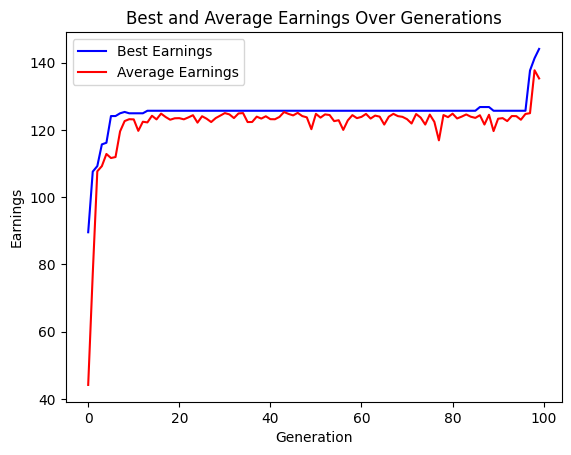

Best params:  [3.895797781699433, -1.5409693053536038, -4.114046112345019, -0.14811411277810488, -1.4493679360327145]


In [357]:
def get_formatted_requests():
    generated_requests = generate_requests()

    requests = []
    for _, row in generated_requests.iterrows():
        req = Request(
            start_time=row['start_time'],
            duration=row['duration_mins'],
            distance=row['distance_km'],
            money=row['net_earnings'],
            start_latitude=row['pickup_lat'],
            start_longitude=row['pickup_lon'],
            end_latitude=row['drop_lat'],
            end_longitude=row['drop_lon']
        )
        requests.append(req)

    return requests

days = [get_formatted_requests() for _ in range(10)]
best_params = train(days, 100, 50)
print("Best params: ", best_params)

with open('model.json', 'w') as f:
    json.dump(best_params, f)